# Imports and configs

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.base import clone
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import polars as pl
import warnings
import h5py
import torch
import random
import timm
import io
import os
import shutil
import scipy
import cv2
import gc

warnings.filterwarnings('ignore')

In [2]:
class CFG:
    test_img_path = '/kaggle/input/isic-2024-challenge/test-image.hdf5'
    train_path = '/kaggle/input/isic-2024-challenge/train-metadata.csv'
    test_path = '/kaggle/input/isic-2024-challenge/test-metadata.csv'
    sample_sub_path = '/kaggle/input/isic-2024-challenge/sample_submission.csv'
    
    resnet_checkpoint_path = '/kaggle/input/skin-cancer-detection-resnet50-training/checkpoints/'
    swin_checkpoint_path = '/kaggle/input/skin-cancer-detection-swin-transformer-training/checkpoints/'
    
    resnet_oof_path = '/kaggle/input/skin-cancer-detection-resnet50-training/resnet50_oof_preds.csv'
    swin_oof_path = '/kaggle/input/skin-cancer-detection-swin-transformer-training/swin_base_patch4_window7_224_oof_preds.csv'

    resnet_checkpoints = [
        'fold_0_epoch_10_pauc_0.119877.pth',
        'fold_1_epoch_16_pauc_0.152112.pth',
        'fold_2_epoch_11_pauc_0.146086.pth',
        'fold_3_epoch_20_pauc_0.161103.pth',
        'fold_4_epoch_48_pauc_0.169901.pth'
    ]
    
    swin_checkpoints = [
        'fold_0_epoch_24_pauc_0.129003.pth',
        'fold_1_epoch_16_pauc_0.162821.pth',
        'fold_2_epoch_30_pauc_0.160597.pth',
        'fold_3_epoch_18_pauc_0.167431.pth',
        'fold_4_epoch_20_pauc_0.169827.pth'
    ]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    swin_model_name = 'swin_base_patch4_window7_224'
    resnet_model_name = "resnet50"
    target = 'target'
    image_size = 224
    val_batch_size = 64
    n_folds = 5
    seed = 35555

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(CFG.seed)

# Loading and processing the datasets

In [4]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
num_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
    'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
    'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL',
    'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
    'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z'
]

new_num_cols = [
    'lesion_size_ratio', 'lesion_shape_index', 'hue_contrast', 'luminance_contrast', 'lesion_color_difference',
    'border_complexity', 'color_uniformity', 'position_distance_3d', 'perimeter_to_area_ratio', 'area_to_perimeter_ratio',
    'lesion_visibility_score', 'symmetry_border_consistency', 'consistency_symmetry_border', 'color_consistency',
    'consistency_color', 'size_age_interaction', 'hue_color_std_interaction', 'lesion_severity_index', 'shape_complexity_index',
    'color_contrast_index', 'log_lesion_area', 'normalized_lesion_size', 'mean_hue_difference', 'std_dev_contrast',
    'color_shape_composite_index', 'lesion_orientation_3d', 'overall_color_difference', 'symmetry_perimeter_interaction',
    'comprehensive_lesion_index', 'color_variance_ratio', 'border_color_interaction', 'border_color_interaction_2',
    'size_color_contrast_ratio', 'age_normalized_nevi_confidence', 'age_normalized_nevi_confidence_2', 'color_asymmetry_index',
    'volume_approximation_3d', 'color_range', 'shape_color_consistency', 'border_length_ratio', 'age_size_symmetry_index',
    'index_age_size_symmetry'
]

cat_cols = [
    'sex', 'anatom_site_general', 'tbp_tile_type',
    'tbp_lv_location', 'tbp_lv_location_simple', 'attribution'
]

image_cols = [
    CFG.resnet_model_name,
    CFG.swin_model_name,
]

norm_cols = [f'{col}_patient_norm' for col in num_cols + new_num_cols]
special_cols = ['count_per_patient']
feature_cols = num_cols + new_num_cols + cat_cols + norm_cols + special_cols + image_cols

In [5]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).median()),
        )
        .with_columns(
            lesion_size_ratio=pl.col('tbp_lv_minorAxisMM') / pl.col('clin_size_long_diam_mm'),
            lesion_shape_index=pl.col('tbp_lv_areaMM2') / (pl.col('tbp_lv_perimeterMM') ** 2),
            hue_contrast=(pl.col('tbp_lv_H') - pl.col('tbp_lv_Hext')).abs(),
            luminance_contrast=(pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs(),
            lesion_color_difference=(pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2).sqrt(),
            border_complexity=pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_symm_2axis'),
            color_uniformity=pl.col('tbp_lv_color_std_mean') / (pl.col('tbp_lv_radial_color_std_max') + 1e-5),
        )
        .with_columns(
            position_distance_3d=(pl.col('tbp_lv_x') ** 2 + pl.col('tbp_lv_y') ** 2 + pl.col('tbp_lv_z') ** 2).sqrt(),
            perimeter_to_area_ratio=pl.col('tbp_lv_perimeterMM') / pl.col('tbp_lv_areaMM2'),
            area_to_perimeter_ratio=pl.col('tbp_lv_areaMM2') / pl.col('tbp_lv_perimeterMM'),
            lesion_visibility_score=pl.col('tbp_lv_deltaLBnorm') + pl.col('tbp_lv_norm_color'),
            combined_anatomical_site=pl.col('anatom_site_general') + '_' + pl.col('tbp_lv_location'),
            symmetry_border_consistency=pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border'),
            consistency_symmetry_border=pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_norm_border') / (pl.col('tbp_lv_symm_2axis') + pl.col('tbp_lv_norm_border')),
        )
        .with_columns(
            color_consistency=pl.col('tbp_lv_stdL') / pl.col('tbp_lv_Lext'),
            consistency_color=pl.col('tbp_lv_stdL') * pl.col('tbp_lv_Lext') / (pl.col('tbp_lv_stdL') + pl.col('tbp_lv_Lext')),
            size_age_interaction=pl.col('clin_size_long_diam_mm') * pl.col('age_approx'),
            hue_color_std_interaction=pl.col('tbp_lv_H') * pl.col('tbp_lv_color_std_mean'),
            lesion_severity_index=(pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_eccentricity')) / 3,
            shape_complexity_index=pl.col('border_complexity') + pl.col('lesion_shape_index'),
            color_contrast_index=pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL') + pl.col('tbp_lv_deltaLBnorm'),
        )
        .with_columns(
            log_lesion_area=(pl.col('tbp_lv_areaMM2') + 1).log(),
            normalized_lesion_size=pl.col('clin_size_long_diam_mm') / pl.col('age_approx'),
            mean_hue_difference=(pl.col('tbp_lv_H') + pl.col('tbp_lv_Hext')) / 2,
            std_dev_contrast=((pl.col('tbp_lv_deltaA') ** 2 + pl.col('tbp_lv_deltaB') ** 2 + pl.col('tbp_lv_deltaL') ** 2) / 3).sqrt(),
            color_shape_composite_index=(pl.col('tbp_lv_color_std_mean') + pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_symm_2axis')) / 3,
            lesion_orientation_3d=pl.arctan2(pl.col('tbp_lv_y'), pl.col('tbp_lv_x')),
            overall_color_difference=(pl.col('tbp_lv_deltaA') + pl.col('tbp_lv_deltaB') + pl.col('tbp_lv_deltaL')) / 3,
        )
        .with_columns(
            symmetry_perimeter_interaction=pl.col('tbp_lv_symm_2axis') * pl.col('tbp_lv_perimeterMM'),
            comprehensive_lesion_index=(pl.col('tbp_lv_area_perim_ratio') + pl.col('tbp_lv_eccentricity') + pl.col('tbp_lv_norm_color') + pl.col('tbp_lv_symm_2axis')) / 4,
            color_variance_ratio=pl.col('tbp_lv_color_std_mean') / pl.col('tbp_lv_stdLExt'),
            border_color_interaction=pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color'),
            border_color_interaction_2=pl.col('tbp_lv_norm_border') * pl.col('tbp_lv_norm_color') / (pl.col('tbp_lv_norm_border') + pl.col('tbp_lv_norm_color')),
            size_color_contrast_ratio=pl.col('clin_size_long_diam_mm') / pl.col('tbp_lv_deltaLBnorm'),
            age_normalized_nevi_confidence=pl.col('tbp_lv_nevi_confidence') / pl.col('age_approx'),
            age_normalized_nevi_confidence_2=(pl.col('clin_size_long_diam_mm')**2 + pl.col('age_approx')**2).sqrt(),
            color_asymmetry_index=pl.col('tbp_lv_radial_color_std_max') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            volume_approximation_3d=pl.col('tbp_lv_areaMM2') * (pl.col('tbp_lv_x')**2 + pl.col('tbp_lv_y')**2 + pl.col('tbp_lv_z')**2).sqrt(),
            color_range=(pl.col('tbp_lv_L') - pl.col('tbp_lv_Lext')).abs() + (pl.col('tbp_lv_A') - pl.col('tbp_lv_Aext')).abs() + (pl.col('tbp_lv_B') - pl.col('tbp_lv_Bext')).abs(),
            shape_color_consistency=pl.col('tbp_lv_eccentricity') * pl.col('tbp_lv_color_std_mean'),
            border_length_ratio=pl.col('tbp_lv_perimeterMM') / (2 * np.pi * (pl.col('tbp_lv_areaMM2') / np.pi).sqrt()),
            age_size_symmetry_index=pl.col('age_approx') * pl.col('clin_size_long_diam_mm') * pl.col('tbp_lv_symm_2axis'),
            index_age_size_symmetry=pl.col('age_approx') * pl.col('tbp_lv_areaMM2') * pl.col('tbp_lv_symm_2axis'),
        )
        .with_columns(
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + 1e-5)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        .with_columns(
            count_per_patient=pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index('isic_id')
    )

In [6]:
# Reference: https://www.kaggle.com/code/greysky/isic-2024-only-tabular-data
def preprocess(df_train, df_test, cat_cols):
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])

    ohe_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[ohe_cols] = encoder.transform(df_train[cat_cols])
    df_test[ohe_cols] = encoder.transform(df_test[cat_cols])

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(ohe_cols)

    return df_train, df_test

In [7]:
train = read_data(CFG.train_path)
test = read_data(CFG.test_path)
train, test = preprocess(train, test, cat_cols)

In [8]:
# Reference: https://www.kaggle.com/code/murashow/tabular-with-image-features-lightgbm?scriptVersionId=192586844
least_important_features = ['onehot_32', 'onehot_6', 'onehot_33', 'onehot_30', 'onehot_26', 'onehot_22', 'onehot_36', 'onehot_4']
train.drop(columns=least_important_features, inplace=True)
for feature in least_important_features:
    feature_cols.remove(feature)

# Adding image model features

In [9]:
class ISICDataset(Dataset):
    def __init__(self, data_path, metadata, transform=None):
        self.data = h5py.File(data_path, 'r')
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = self.metadata.iloc[idx]['isic_id']
        image = np.array(self.data[img_name])
        image = np.array(Image.open(io.BytesIO(image)))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if 'target' in self.metadata.columns:
            label = int(self.metadata['target'].iloc[idx])
            return image, label
        else:
            return image, 0

In [10]:
transforms = A.Compose([
    A.Resize(CFG.image_size, CFG.image_size),
    A.Normalize(
        mean=[0.4815, 0.4578, 0.4082],
        std=[0.2686, 0.2613, 0.2758],
        max_pixel_value=255.0),
    ToTensorV2(),
])

In [11]:
class ResNet(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super(ResNet, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, in_chans=3)
        num_features = 1000
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

In [12]:
class SwinTransformer(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super(SwinTransformer, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.model.num_features * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [13]:
class Trainer:
    def __init__(self, device, model, test_dataloader, checkpoint_path):
        self.device = device
        self.model = model
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path

    def predict(self):
        self.model.load_state_dict(torch.load(self.checkpoint_path))
        self.model.eval()

        preds = []
        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=len(self.test_dataloader))
            for batch in loop:
                x, _ = batch
                x = x.to(self.device)
                y_hat = self.model(x).squeeze()
                preds.extend(y_hat.detach().cpu().numpy())
                loop.set_description(f'Prediction')

        return preds

In [14]:
def get_image_test_preds(model, checkpoint_path, checkpoints):
    test_metadata = pd.read_csv(CFG.test_path)
    test_preds = []

    for i in range(len(checkpoints)):
        test_dataset = ISICDataset(CFG.test_img_path, test_metadata, transforms)
        test_dataloader = DataLoader(test_dataset, batch_size=CFG.val_batch_size, shuffle=False, num_workers=4)
        
        _model = model.to(CFG.device)
        
        trainer = Trainer(
            device=CFG.device,
            model=_model,
            test_dataloader=test_dataloader,
            checkpoint_path=checkpoint_path + checkpoints[i]
        )

        preds = trainer.predict()
        test_preds.append(preds)

        del test_dataset, test_dataloader, _model, trainer
        gc.collect()
        torch.cuda.empty_cache()

    return test_preds

In [15]:
resnet_oof_pred_probs = pd.read_csv(CFG.resnet_oof_path, index_col='isic_id')[[CFG.resnet_model_name]]
swin_oof_pred_probs = pd.read_csv(CFG.swin_oof_path, index_col='isic_id')[[CFG.swin_model_name]]

train = pd.merge(train, resnet_oof_pred_probs, left_index=True, right_index=True, how="left")
train = pd.merge(train, swin_oof_pred_probs, left_index=True, right_index=True, how="left")

In [16]:
resnet_test_preds = get_image_test_preds(ResNet(CFG.resnet_model_name), CFG.resnet_checkpoint_path, CFG.resnet_checkpoints)
swin_test_preds = get_image_test_preds(SwinTransformer(CFG.swin_model_name), CFG.swin_checkpoint_path, CFG.swin_checkpoints)

sample_sub = pd.read_csv(CFG.test_path)
sample_sub[CFG.resnet_model_name] = np.mean(resnet_test_preds, axis=0)
sample_sub[CFG.swin_model_name] = np.mean(swin_test_preds, axis=0)
sample_sub = sample_sub[['isic_id', CFG.resnet_model_name, CFG.swin_model_name]].set_index('isic_id')
test = pd.merge(test, sample_sub, left_index=True, right_index=True)

Prediction: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


In [17]:
X = train.drop(CFG.target, axis=1)[feature_cols]
y = train[CFG.target]

X_test = test[feature_cols]

groups = train['patient_id']

# Training base models

In [18]:
def p_roc_auc_score(y_true, y_pred):
    min_tpr = 0.80
    v_gt = abs(np.asarray(y_true) - 1)
    v_pred = -1.0*np.asarray(y_pred)
    max_fpr = abs(1-min_tpr)
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError('Expected min_tpr in range [0, 1), got: %r' % min_tpr)

    stop = np.searchsorted(fpr, max_fpr, 'right')
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)

    return partial_auc

In [19]:
class Trainer:
    def __init__(self, model, n_folds=CFG.n_folds):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')

        scores = []
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))

        split = StratifiedGroupKFold(n_splits=self.n_folds, random_state=CFG.seed, shuffle=True).split(X, y, groups=groups)    
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if isinstance(model, LogisticRegression):
                n_iter = model.n_iter_
                coeffs += model.coef_ / self.n_folds

            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs

            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds

            score = p_roc_auc_score(y_val, y_pred_probs[:, 1])
            scores.append(score)

            del model
            gc.collect()

            if isinstance(self.model, LogisticRegression):
                print(f'--- Fold {fold_idx + 1} - pAUC: {score:.6f} (iterations: {n_iter[0]})')
            else:
                print(f'--- Fold {fold_idx + 1} - pAUC: {score:.6f}')

        print(f'\n\n------ pAUC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')

        return oof_pred_probs[:, 1], test_pred_probs[:, 1], scores, coeffs

In [20]:
lgbm_params = {
    'bagging_fraction': 0.3465000550081851,
    'bagging_freq': 8,
    'colsample_bynode': 0.4167820599704415,
    'colsample_bytree': 0.4421463443520458,
    'learning_rate': 0.001811692225603902,
    'max_depth': 35,
    'min_data_in_leaf': 81,
    'n_estimators': 863,
    'num_leaves': 67,
    'random_state': CFG.seed,
    'reg_alpha': 7.968656148568324,
    'reg_lambda': 9.88332614486686,
    'scale_pos_weight': 7.56776875175158,
    'verbosity': -1
}

cb_params = {
    'iterations': 342,
    'l2_leaf_reg': 8.039344289318391,
    'learning_rate': 0.006520436774676923,
    'max_depth': 9,
    'min_data_in_leaf': 433,
    'random_state': CFG.seed,
    'random_strength': 0.33854201785212,
    'scale_pos_weight': 35.28515757349715,
    'verbose': False
}

xgb_params = {
    'alpha': 2.46087333598469,
    'colsample_bylevel': 0.4550137505808455,
    'colsample_bynode': 0.8906112494040207,
    'colsample_bytree': 0.3871006242590642,
    'lambda': 7.262864094940608,
    'learning_rate': 0.020978075381692652,
    'max_depth': 86,
    'n_estimators': 693,
    'random_state': CFG.seed,
    'scale_pos_weight': 12.73805076866774,
    'subsample': 0.8094914802673989,
    'verbosity': 0
}

In [21]:
paucs = {}

test_pred_probs = {}
oof_pred_probs = {}

In [22]:
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
lgbm_oof_pred_probs, lgbm_test_pred_probs, lgbm_scores, _ = lgbm_trainer.fit_predict(X, y, X_test)
oof_pred_probs['LightGBM'] = lgbm_oof_pred_probs
test_pred_probs['LightGBM'] = lgbm_test_pred_probs
paucs['LightGBM'] = lgbm_scores

Training LGBMClassifier

--- Fold 1 - pAUC: 0.160580
--- Fold 2 - pAUC: 0.172507
--- Fold 3 - pAUC: 0.176409
--- Fold 4 - pAUC: 0.174373
--- Fold 5 - pAUC: 0.178895


------ pAUC: 0.172553 ± 0.006352


In [23]:
cb_model = CatBoostClassifier(**cb_params)
cb_trainer = Trainer(cb_model)
cb_oof_pred_probs, cb_test_pred_probs, cb_scores, _ = cb_trainer.fit_predict(X, y, X_test)
oof_pred_probs['CatBoost'] = cb_oof_pred_probs
test_pred_probs['CatBoost'] = cb_test_pred_probs
paucs['CatBoost'] = cb_scores

Training CatBoostClassifier

--- Fold 1 - pAUC: 0.163279
--- Fold 2 - pAUC: 0.180127
--- Fold 3 - pAUC: 0.174964
--- Fold 4 - pAUC: 0.173076
--- Fold 5 - pAUC: 0.185970


------ pAUC: 0.175483 ± 0.007570


In [24]:
xgb_model = XGBClassifier(**xgb_params)
xgb_trainer = Trainer(xgb_model)
xgb_oof_pred_probs, xgb_test_pred_probs, xgb_scores, _ = xgb_trainer.fit_predict(X, y, X_test)
oof_pred_probs['XGBoost'] = xgb_oof_pred_probs
test_pred_probs['XGBoost'] = xgb_test_pred_probs
paucs['XGBoost'] = xgb_scores

Training XGBClassifier

--- Fold 1 - pAUC: 0.170216
--- Fold 2 - pAUC: 0.169767
--- Fold 3 - pAUC: 0.175603
--- Fold 4 - pAUC: 0.176382
--- Fold 5 - pAUC: 0.181127


------ pAUC: 0.174619 ± 0.004227


# Stacking with logistic regression

In [25]:
X = pd.DataFrame(oof_pred_probs).rank(pct=True)
X_test = pd.DataFrame(test_pred_probs).rank(pct=True)

In [26]:
lr_model = LogisticRegression(max_iter=150, random_state=CFG.seed, solver='liblinear')

ensemble_trainer = Trainer(lr_model)
ensemble_oof_pred_probs, ensemble_test_pred_probs, ensemble_scores, coeffs = ensemble_trainer.fit_predict(X, y, X_test)
paucs['Ensemble'] = ensemble_scores

Training LogisticRegression

--- Fold 1 - pAUC: 0.167547 (iterations: 13)
--- Fold 2 - pAUC: 0.177272 (iterations: 13)
--- Fold 3 - pAUC: 0.178009 (iterations: 13)
--- Fold 4 - pAUC: 0.177127 (iterations: 13)
--- Fold 5 - pAUC: 0.183489 (iterations: 13)


------ pAUC: 0.176689 ± 0.005140


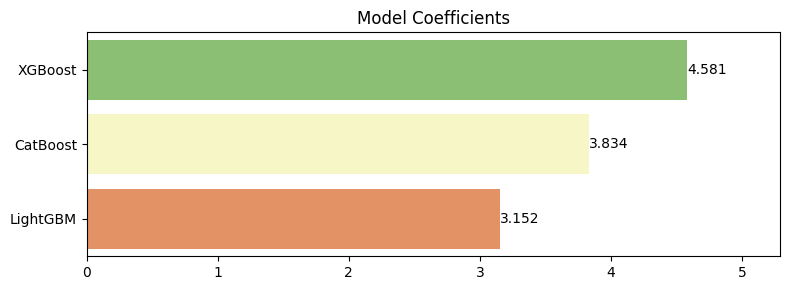

In [27]:
sorted_indices = np.argsort(coeffs[0])[::-1]
sorted_coeffs = np.array(coeffs[0])[sorted_indices]
sorted_model_names = np.array(list(oof_pred_probs.keys()))[sorted_indices]

plt.figure(figsize=(8, 3))
ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
    if value > 0:
        ax.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
    else:
        ax.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

xlim = ax.get_xlim()
ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))
        
plt.title('Model Coefficients')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Visualizing the results

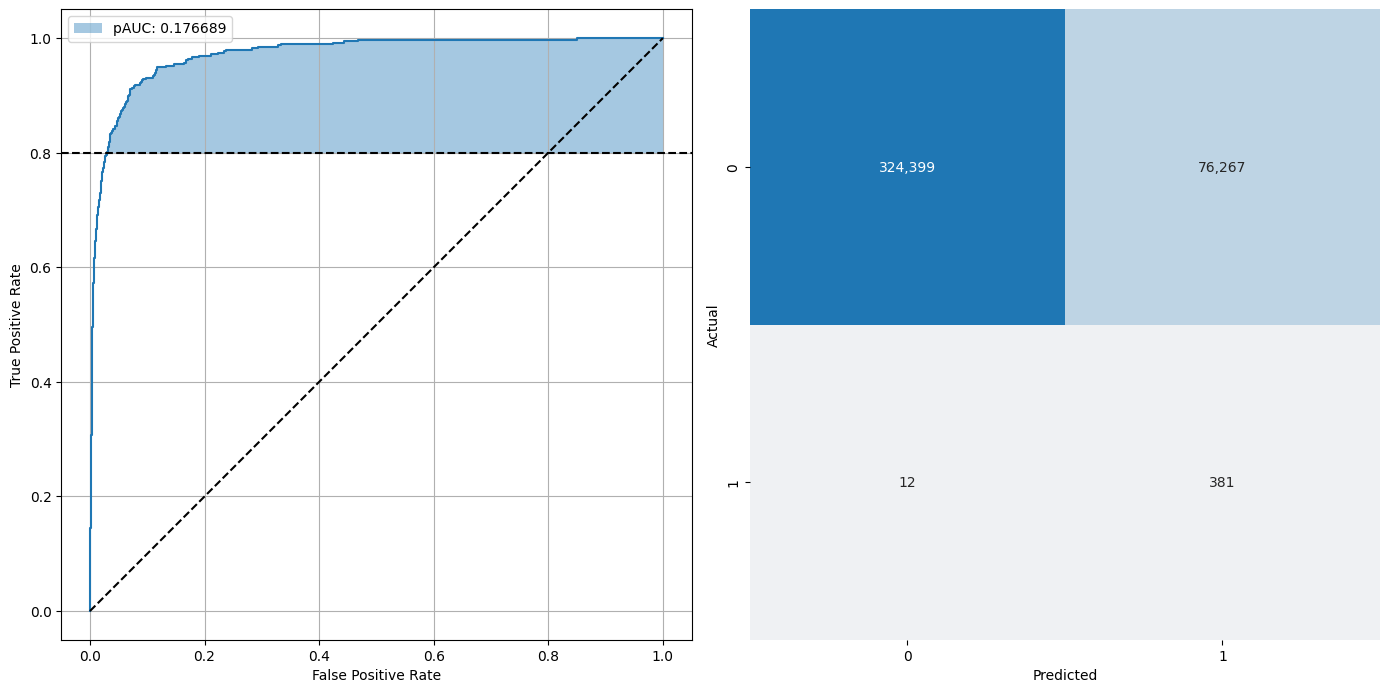

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

fpr, tpr, thresholds = roc_curve(y, ensemble_oof_pred_probs)
axes[0].plot(fpr, tpr)
axes[0].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[0].fill_between(fpr, tpr, 0.8, where=(tpr >= 0.8), alpha=0.4, label=f'pAUC: {np.mean(ensemble_scores):.6f}')
axes[0].axhline(y=0.8, color='black', linestyle='--')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].legend()
axes[0].grid(True)
axes[0].set_aspect('equal', adjustable='box')

specificity = 1 - fpr
threshold_index = np.where(specificity >= 0.80)[0][-1]
optimal_threshold = thresholds[threshold_index]

y_pred = (ensemble_oof_pred_probs >= optimal_threshold).astype(int)
cm = confusion_matrix(y, y_pred)
sns.heatmap(
    cm, 
    annot=True, 
    fmt=',', 
    ax=axes[1], 
    cbar=False,
    cmap=sns.light_palette(sns.color_palette()[0], reverse=False, as_cmap=True), 
)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

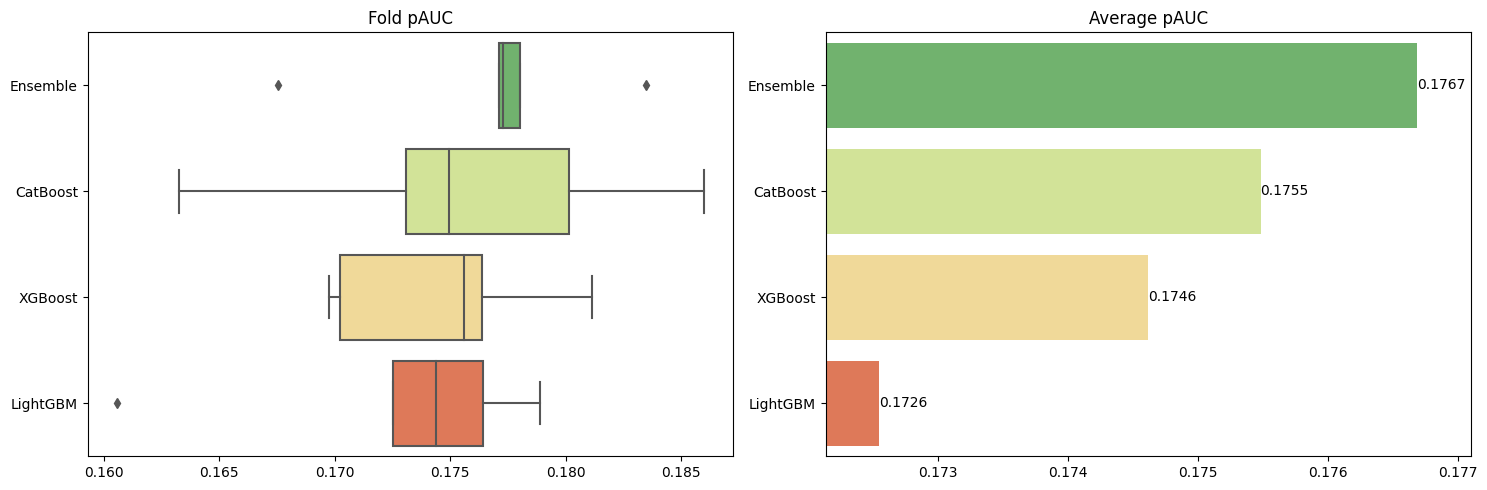

In [29]:
paucs = pd.DataFrame(paucs)
mean_paucs = paucs.mean().sort_values(ascending=False)
order = paucs.mean().sort_values(ascending=False).index.tolist()

min_pauc = mean_paucs.min()
max_pauc = mean_paucs.max()
padding = (max_pauc - min_pauc) * 0.1
lower_limit = min_pauc - padding
upper_limit = max_pauc + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=paucs, order=order, ax=axs[0], orient='h', palette="RdYlGn_r")
axs[0].set_title('Fold pAUC')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_paucs.values, y=mean_paucs.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title('Average pAUC')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_paucs.values):
    barplot.text(score, i, round(score, 4), va='center')

plt.tight_layout()
plt.show()

# Submission

In [30]:
sub = pd.read_csv(CFG.sample_sub_path)
sub['isic_id'] = sub['isic_id']
sub[CFG.target] = ensemble_test_pred_probs
sub.to_csv('submission.csv', index=False)
sub.head()

,isic_id,target
0,ISIC_0015657,0.013004
1,ISIC_0015729,0.000006
2,ISIC_0015740,0.000279


In [31]:
shutil.rmtree('catboost_info')